In [1]:
import pandas as pd
import matplotlib.pyplot as plt

In [2]:
import warnings
warnings.filterwarnings("ignore")

In [3]:
df = pd.read_csv("survival_data.csv")
df['censored'] = 1-df.broken
df = df.sort_values('lifetime')
df.head()

,lifetime,broken,pressureInd,moistureInd,temperatureInd,team,provider,censored
52,1,0,72.423129,120.484155,116.400433,TeamB,Provider2,1
205,1,0,92.100802,89.994611,97.292290,TeamB,Provider1,1
464,1,0,141.042595,113.358822,91.310554,TeamC,Provider2,1
71,1,0,107.785993,117.390336,113.377308,TeamB,Provider4,1
209,1,0,104.658530,107.537666,126.374317,TeamB,Provider1,1


In [4]:
km_estimator = pd.DataFrame(columns = ['lifetime', 'broken', 'censored', 'n_sample', 'HF', 'cHF', 'survival'])
km_estimator.lifetime = df.lifetime.unique()

n = len(df)
cHF = 0
survival = 1
ind = 0
for t in km_estimator.lifetime:
    df_filter = df.loc[df.lifetime == t]
    km_estimator.loc[ind, 'broken'] = df_filter['broken'].sum()
    km_estimator.loc[ind, 'censored'] = df_filter['censored'].sum()
    
    
    km_estimator.n_sample[ind] = n
    n -= (df_filter['broken'].sum() + df_filter['censored'].sum())
    
    km_estimator.HF[ind] = km_estimator.broken[ind]/km_estimator.n_sample[ind]
    
    cHF += km_estimator.HF[ind]
    km_estimator.cHF[ind] = cHF
    
    survival *= (1-km_estimator.HF[ind])
    km_estimator.survival[ind] = survival
    
    ind += 1
    
    
km_estimator

,lifetime,broken,censored,n_sample,HF,cHF,survival
0,1,0,5,1000,0,0,1
1,2,0,11,995,0,0,1
2,3,0,3,984,0,0,1
3,4,0,8,981,0,0,1
4,5,0,10,973,0,0,1
...,...,...,...,...,...,...,...
85,88,42,4,112,0.375,1.41089,0.204093
86,89,1,0,66,0.0151515,1.42605,0.201001
87,90,0,1,65,0,1.42605,0.201001
88,92,32,0,64,0.5,1.92605,0.1005


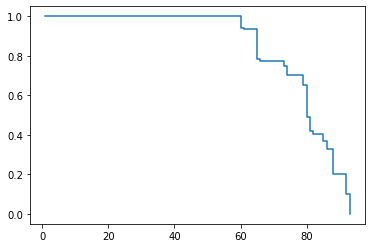

In [5]:
plt.plot(km_estimator.lifetime, km_estimator.survival, drawstyle = 'steps-post')

In [6]:
from lifelines import KaplanMeierFitter
km_fitter = KaplanMeierFitter()
km_fitter.fit(df.lifetime, df.broken)

<lifelines.KaplanMeierFitter: fitted with 1000 observations, 603 censored>

<AxesSubplot:xlabel='timeline'>

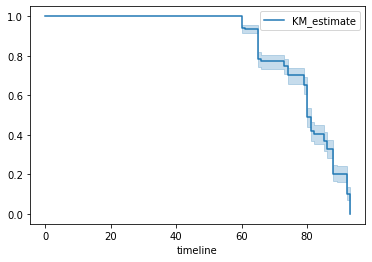

In [7]:
km_fitter.plot(ci_show=True)

In [8]:
from lifelines import CoxPHFitter

In [9]:
df = pd.read_csv("survival_data.csv")
df = pd.get_dummies(df, drop_first = True)

df = df.drop(['pressureInd', 'moistureInd', 'team_TeamB'], axis = 'columns')
df

,lifetime,broken,temperatureInd,team_TeamC,provider_Provider2,provider_Provider3,provider_Provider4
0,56,0,96.517159,0,0,0,1
1,81,1,87.271062,1,0,0,1
2,60,0,112.196170,0,0,0,0
3,86,1,72.025374,1,1,0,0
4,34,0,103.756271,0,0,0,0
...,...,...,...,...,...,...,...
995,88,1,99.861456,0,0,0,1
996,88,1,95.075631,0,0,0,1
997,22,0,83.221220,0,0,0,0
998,78,0,83.421491,0,0,0,1


In [10]:
from sklearn.model_selection import train_test_split
train, test = train_test_split(df, test_size=0.3)

In [11]:
cph = CoxPHFitter()
cph.fit(train, duration_col='lifetime', event_col='broken', step_size = .01)

<lifelines.CoxPHFitter: fitted with 700 observations, 411 censored>

In [12]:
cph.print_summary()

<lifelines.CoxPHFitter: fitted with 700 observations, 411 censored>
      duration col = 'lifetime'
         event col = 'broken'
number of subjects = 700
  number of events = 289
    log-likelihood = -908.00
  time fit was run = 2022-02-10 11:32:41 UTC

---
                    coef  exp(coef)  se(coef)      z      p  -log2(p)  lower 0.95  upper 0.95
temperatureInd      0.01       1.01      0.00   4.25 <0.005     15.52        0.01        0.02
team_TeamC          2.91      18.30      0.23  12.67 <0.005    119.75        2.46        3.36
provider_Provider2 -6.02       0.00      0.42 -14.47 <0.005    155.19       -6.83       -5.20
provider_Provider3  5.05     156.67      0.41  12.44 <0.005    115.66        4.26        5.85
provider_Provider4 -4.41       0.01      0.35 -12.71 <0.005    120.61       -5.09       -3.73
---
Concordance = 1.00
Log-likelihood ratio test = 967.72 on 5 df, -log2(p)=685.09


<AxesSubplot:xlabel='log(HR) (95% CI)'>

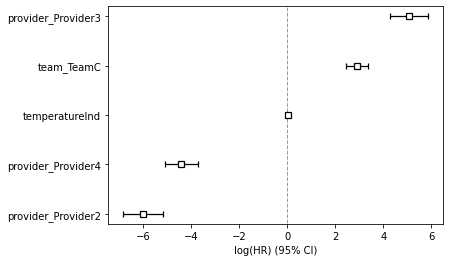

In [13]:
cph.plot()

In [14]:
test_broken = test[test.broken == 1]
ypred = cph.predict_expectation(test_broken)
ypred.head()

,0
179,67.865300
310,79.483286
676,61.211801
170,91.134252
478,81.337617


Text(0, 0.5, 'Predictions')

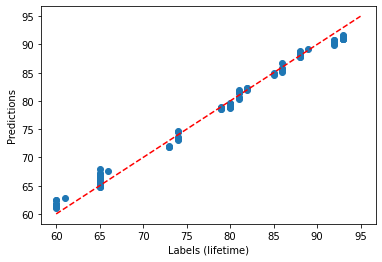

In [15]:
plt.scatter(test_broken.lifetime, ypred)
plt.plot([60, 95], [60, 95], 'r--')
plt.xlabel('Labels (lifetime)')
plt.ylabel('Predictions')

<AxesSubplot:>

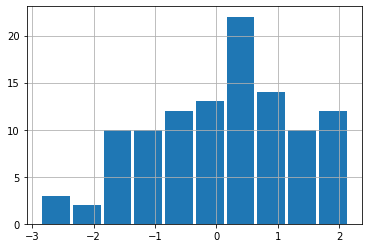

In [16]:
error = test_broken.lifetime - ypred[0]
error.hist(rwidth=0.9)